In [5]:
import sys
sys.path.append('../../')
sys.path.append('../')

import torch as th
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from lgd.degradations import *
from lgd.optimizers.learnable import LearnedGradientDescentOptimizer
from lgd.modules.srresnet import MSRResNet
DEVICE = 'cpu'

def psnr(x, y):
    se = th.nn.functional.mse_loss(x, y, reduction="none")
    if len(se.shape) == 1:
        mse = se
    else:
        mse = se.mean(dim=list(range(1, len(se.shape))))
    psnr = 10 * th.log10(th.tensor(1 ** 2) / mse)
    return psnr

def crop_for_kernel(imgs, kernel_size):
    shape = (kernel_size, kernel_size)
    p_h = (shape[-2] - 1) // 2
    a_h = (shape[-2] - 1) % 2
    p_w = (shape[-1] - 1) // 2
    a_w = (shape[-1] - 1) % 2

    # extracting the center part
    ret = imgs[..., (p_h + a_h):-p_h, (p_w + a_w):-p_w]
    return ret

# Loading data

In [10]:
gt_data = sorted(glob('/Users/ia_koshelev/Downloads/CBSD68-dataset/CBSD68/original_png/*.png'))
gt = th.FloatTensor(cv2.imread(random.choice(gt_data))).div(255).to(device=DEVICE).permute(2, 0, 1).unsqueeze(0).contiguous()

# Init degradation and LGD solver

In [34]:
path_to_checkpoint = '/Users/ia_koshelev/Downloads/ckpts/lgd_deblur-21_(stds_1-5)_hidden_rnn10.pth'
noise_std = 25/255
num_steps = 10

degradation = BlurDegradation(device=DEVICE, kernel_size=21)
ckpt = th.load(path_to_checkpoint, map_location=DEVICE)
backbone_in_channel = ckpt['backbone.conv_first.weight'].shape[1]
backbone = MSRResNet(num_in_ch=backbone_in_channel, num_out_ch=3, num_feat=64, num_block=4, upscale=1).to(DEVICE)
backbone_hidden_state = None
if np.any(['hidden_state' in key for key in ckpt]):
    backbone_hidden_state = MSRResNet(num_in_ch=backbone_in_channel, num_out_ch=1, num_feat=16, num_block=2, 
                                      upscale=1).to(DEVICE)
solver = LearnedGradientDescentOptimizer(degradation, backbone, num_steps, hidden_state_network=backbone_hidden_state, 
                                         device=DEVICE, hidden_state_num_channels=1)
solver.load_state_dict(ckpt)

<All keys matched successfully>

# Look at images

## Degrade and restore

In [42]:
noisy = degradation.init_random_parameters_and_degrade(gt, 1/255, 5/255)
with th.no_grad():
    result = solver.restore((noisy - 0.5)*2)
result = th.clamp((result + 1)/2, 0, 1)

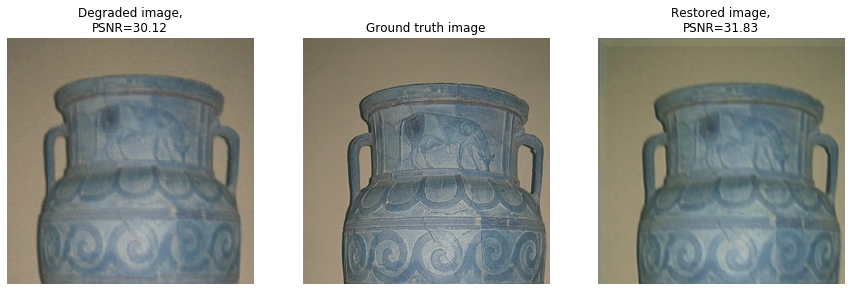

In [43]:
psnr_noisy = np.round(psnr(noisy, crop_for_kernel(gt, 21)).cpu().numpy(), 2)[0]
psnr_result = np.round(psnr(crop_for_kernel(result, 21), crop_for_kernel(gt, 21)).cpu().numpy(), 2)[0]

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
ax[0].imshow(noisy[0].permute(1,2,0).cpu()[:256, :256])
ax[0].axis('off')
ax[0].set_title(f'Degraded image,\nPSNR={str(psnr_noisy)}')
ax[1].imshow(gt[0].permute(1,2,0).cpu()[:256, :256])
ax[1].axis('off')
ax[1].set_title('Ground truth image');
ax[2].imshow(result[0].permute(1,2,0).cpu()[:256, :256])
ax[2].axis('off')
ax[2].set_title(f'Restored image,\nPSNR={str(psnr_result)}');

## By stages

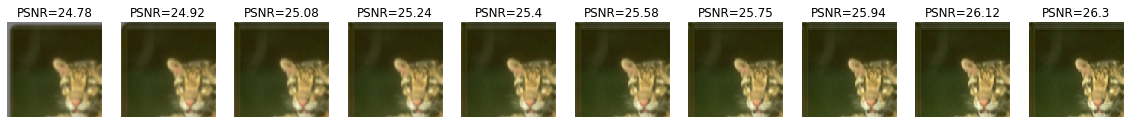

In [47]:
gt  = random.choice(gt_data)
gt = th.FloatTensor(cv2.cvtColor(cv2.imread(gt), cv2.COLOR_BGR2RGB)).div(255).to(device=DEVICE).permute(2, 0, 1).unsqueeze(0).contiguous()
noisy = degradation.init_random_parameters_and_degrade(gt, 1/255, 5/255)

with th.no_grad():
    result = solver.restore((noisy - 0.5)*2, track_updates_history=True)
result = (th.cat(result, dim=0) + 1)/2
result = th.clamp(result, 0, 1)

fig, ax = plt.subplots(nrows=1, ncols=num_steps, figsize=(2*num_steps, 2))
for i in range(num_steps):
    p = np.round(psnr(crop_for_kernel(result, 21)[i], crop_for_kernel(gt, 21)[0])[0].cpu().numpy(), 2)
    ax[i].imshow(result[i, :, :128, :128].permute(1,2,0).cpu())
    ax[i].axis('off')
    ax[i].set_title(f'PSNR={str(p)}')